/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_55958/1426779762.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

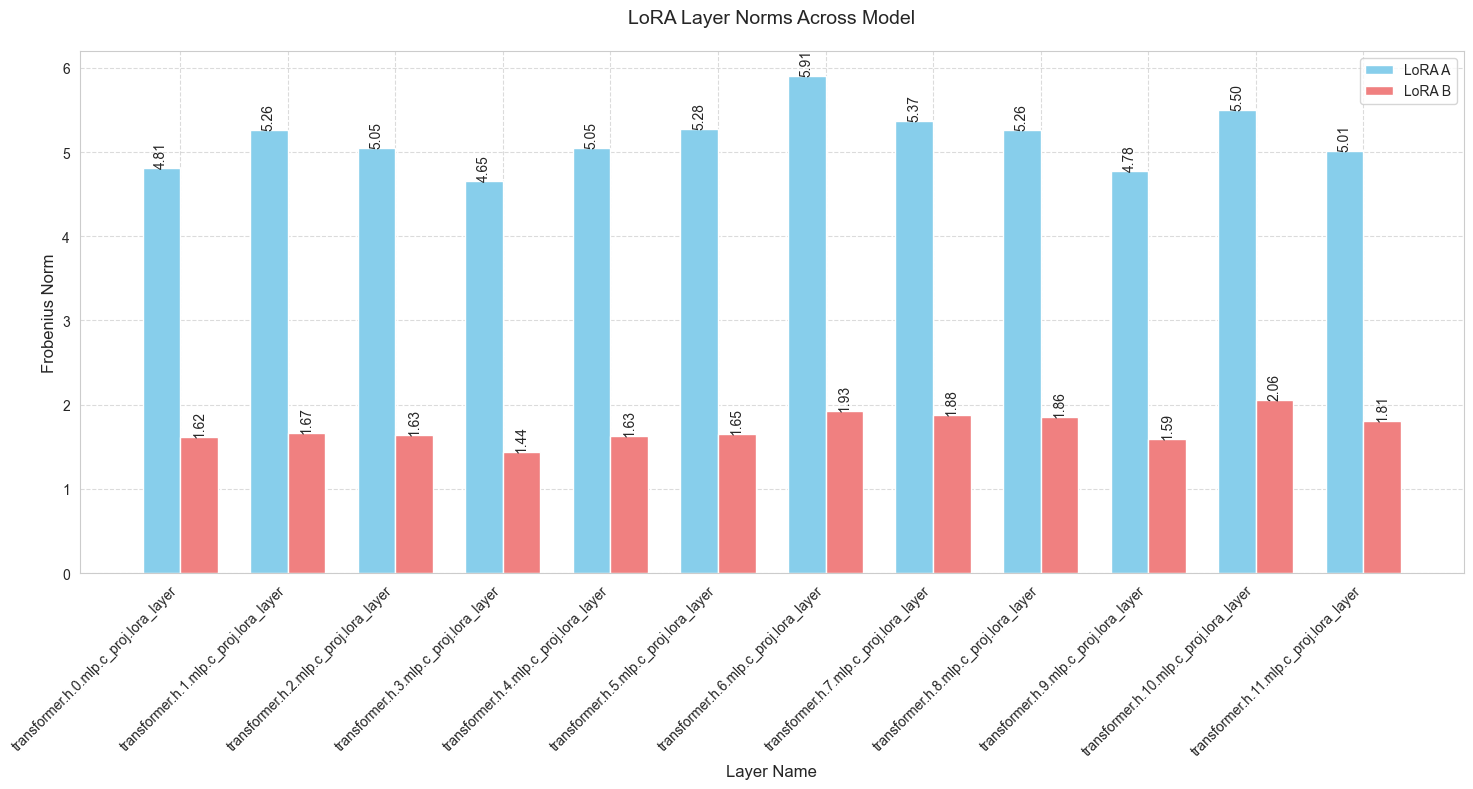


Summary Statistics:
Average LoRA A norm: 5.1605
Average LoRA B norm: 1.7303
Max LoRA A norm: 5.9067
Max LoRA B norm: 2.0563


In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Load the checkpoint
checkpoint_path = "output_lora_15/output_lora_r256_a128_hops1-6/model_epoch_40.pt"  # Replace with your checkpoint path
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Initialize lists to store norms
lora_a_norms = []
lora_b_norms = []
layer_names = []

# Extract LoRA parameters and calculate norms
for name, param in checkpoint.items():
    if "lora_A" in name:
        layer_name = name.split(".lora_A")[0]
        layer_names.append(layer_name)
        
        # Calculate Frobenius norm for lora_A
        lora_a_norm = torch.norm(param, p='fro').item()
        lora_a_norms.append(lora_a_norm)
        
        # Get corresponding lora_B parameter and calculate its norm
        lora_b_name = name.replace("lora_A", "lora_B")
        if lora_b_name in checkpoint:
            lora_b_param = checkpoint[lora_b_name]
            lora_b_norm = torch.norm(lora_b_param, p='fro').item()
            lora_b_norms.append(lora_b_norm)

# Create figure and axis
plt.figure(figsize=(15, 8))

# Set style
sns.set_style("whitegrid")

# Create x-axis positions
x = np.arange(len(layer_names))
width = 0.35

# Create grouped bar plot
plt.bar(x - width/2, lora_a_norms, width, label='LoRA A', color='skyblue')
plt.bar(x + width/2, lora_b_norms, width, label='LoRA B', color='lightcoral')

# Customize the plot
plt.xlabel('Layer Name', fontsize=12)
plt.ylabel('Frobenius Norm', fontsize=12)
plt.title('LoRA Layer Norms Across Model', fontsize=14, pad=20)
plt.xticks(x, layer_names, rotation=45, ha='right')
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Add value annotations on top of bars
for i, v in enumerate(lora_a_norms):
    plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
for i, v in enumerate(lora_b_norms):
    plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

# Show plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average LoRA A norm: {np.mean(lora_a_norms):.4f}")
print(f"Average LoRA B norm: {np.mean(lora_b_norms):.4f}")
print(f"Max LoRA A norm: {np.max(lora_a_norms):.4f}")
print(f"Max LoRA B norm: {np.max(lora_b_norms):.4f}")

KeyboardInterrupt: 

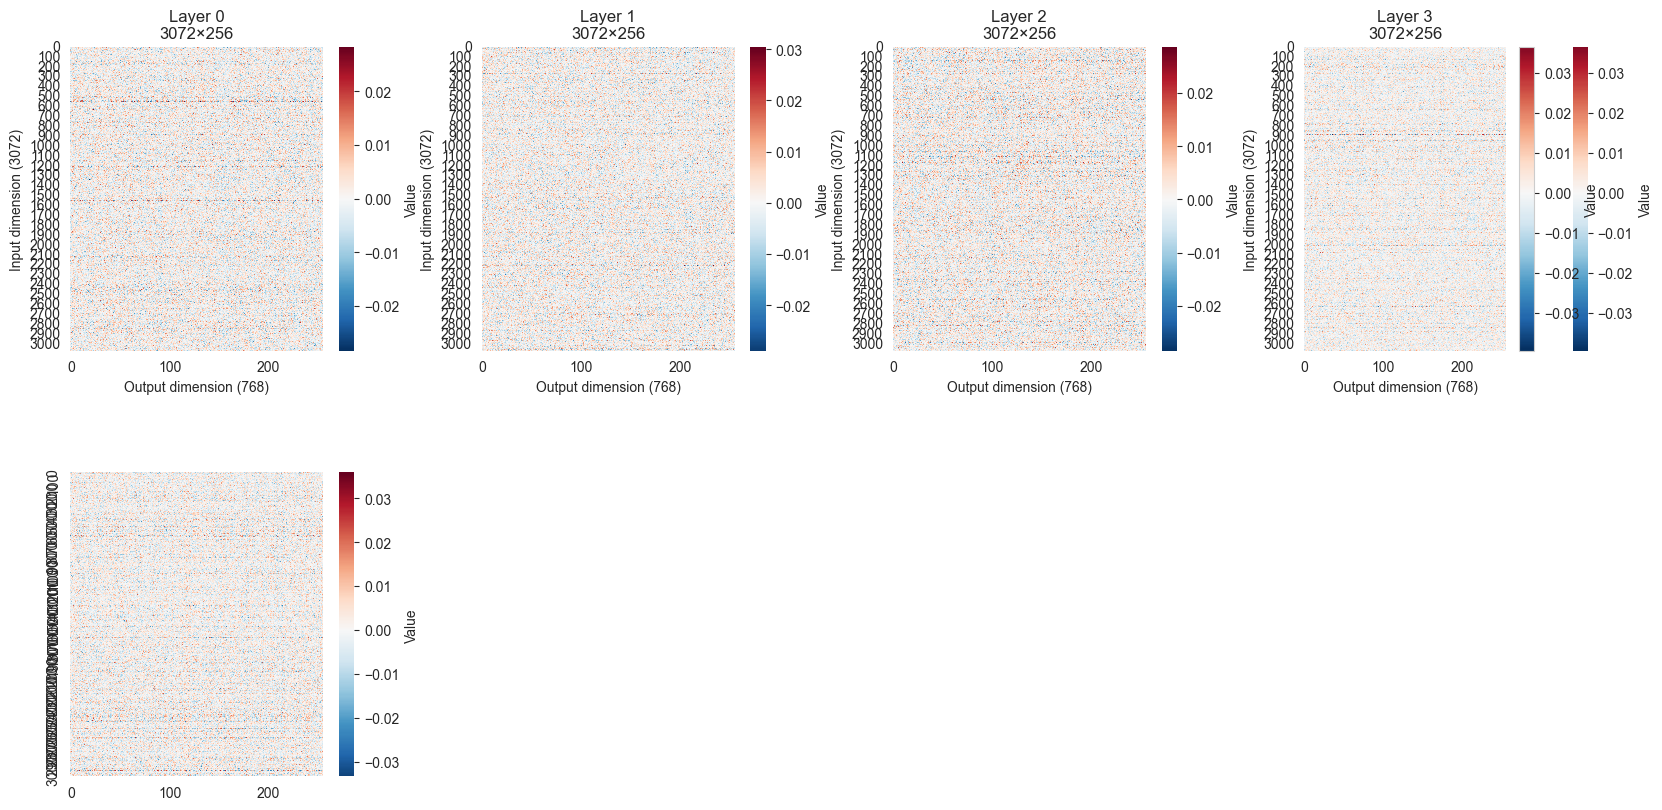

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_lora_layer(matrix, title, ax):
    # Create heatmap with adjusted aspect ratio
    sns.heatmap(matrix,
                cmap='RdBu_r',
                center=0,
                ax=ax,
                cbar_kws={'label': 'Value'},
                xticklabels=100,  # Show fewer ticks for readability
                yticklabels=100)
    
    # Adjust aspect ratio to make it more square-like
    ax.set_aspect('auto')  # This allows the plot to fill the available space
    
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Output dimension (768)')
    ax.set_ylabel('Input dimension (3072)')

# Create a figure with proper spacing
fig = plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Create subplots in a 3x4 grid
for idx, layer_name in enumerate(layer_names):
    ax = plt.subplot(3, 4, idx + 1)
    
    # Get LoRA matrices
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    
    # Calculate effective transformation
    matrix = lora_a #@ lora_b
    
    # Create title with layer info
    title = f'Layer {idx}\n{matrix.shape[0]}×{matrix.shape[1]}'
    
    # Plot the layer
    plot_lora_layer(matrix, title, ax)
    
    # Add colorbar
    if idx % 4 == 3:  # Add colorbar for rightmost plots
        plt.colorbar(ax.collections[0], ax=ax, label='Value')

plt.suptitle('LoRA Layer Transformations', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print statistics for each layer
print("\nLayer Statistics:")
for idx, layer_name in enumerate(layer_names):
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu()
    product = lora_a @ lora_b
    
    print(f"\nLayer {idx}:")
    print(f"Max value: {torch.max(product):.4f}")
    print(f"Min value: {torch.min(product):.4f}")
    print(f"Mean value: {torch.mean(product):.4f}")
    print(f"Std deviation: {torch.std(product):.4f}")

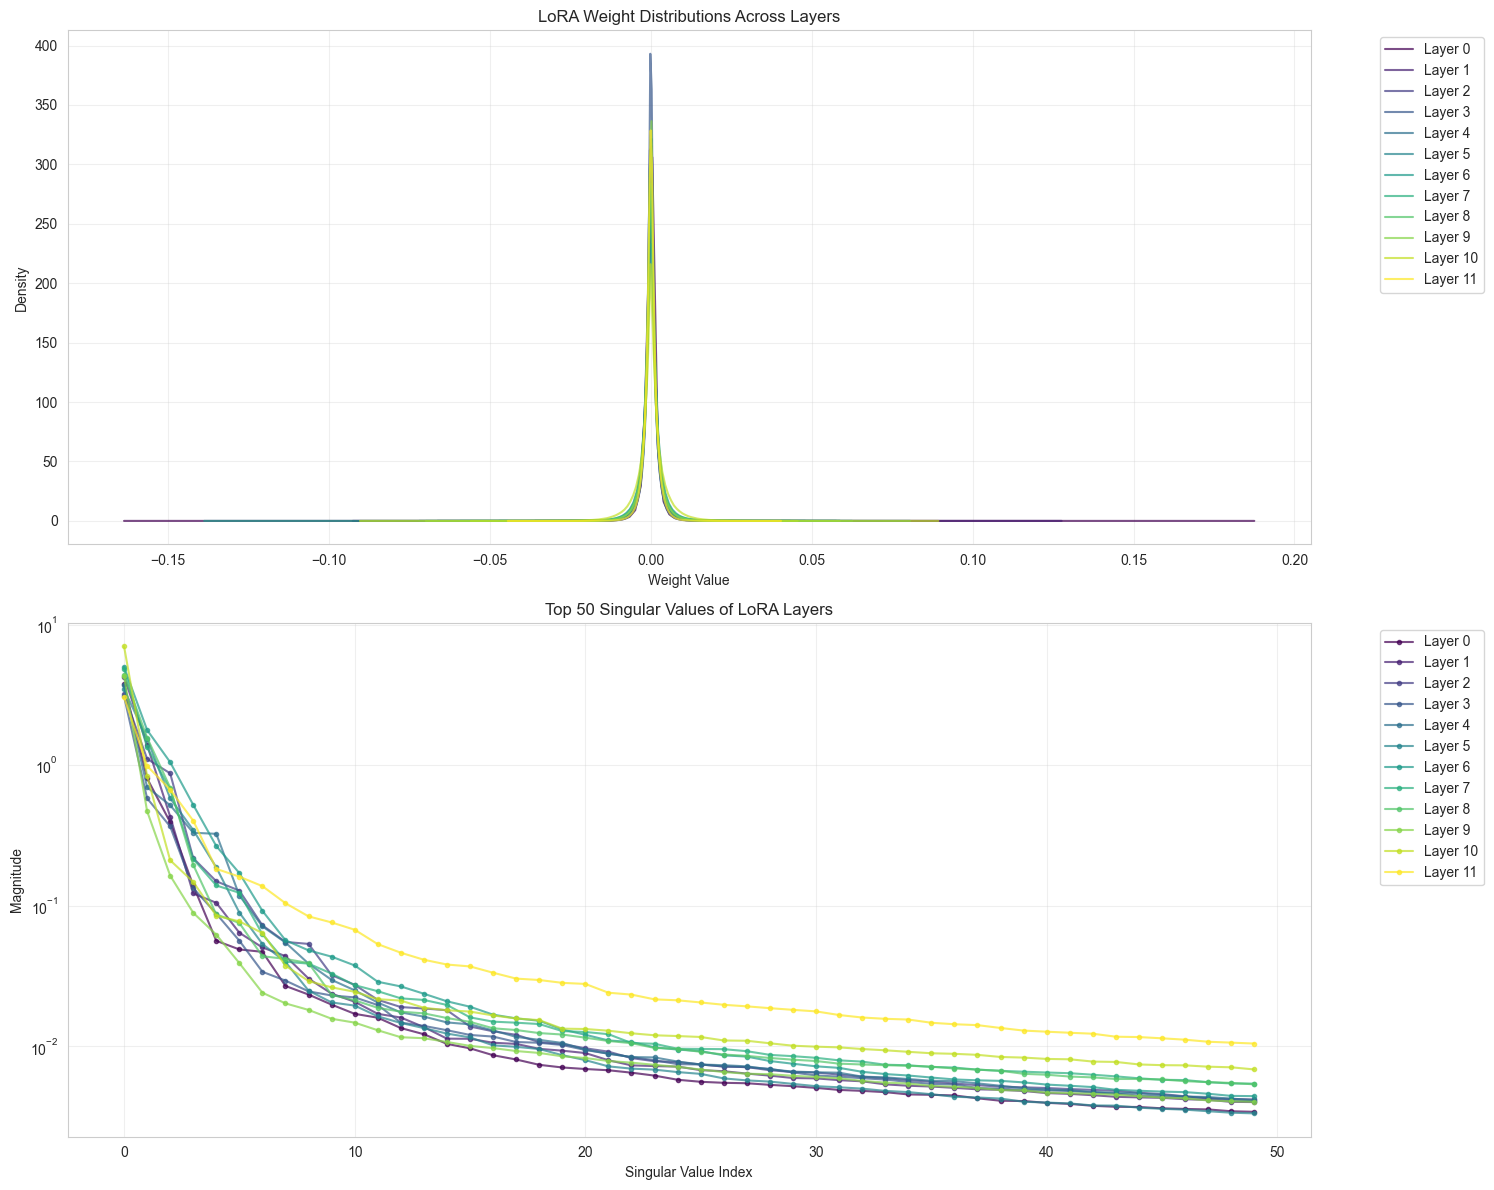


Layer Statistics:

Layer 0:
Max singular value: 3.7600
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 88.32%

Layer 1:
Max singular value: 4.2747
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 88.59%

Layer 2:
Max singular value: 3.1981
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 84.63%

Layer 3:
Max singular value: 3.0963
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 84.19%

Layer 4:
Max singular value: 3.7003
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 85.32%

Layer 5:
Max singular value: 3.4888
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 89.05%

Layer 6:
Max singular value: 5.0096
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 88.19%

Layer 7:
Max singular value: 4.8746
Effective rank (>1e-5): 256
Total variance explained by top 5 components: 86.46%

Layer 8:
Max singular value: 4.4027


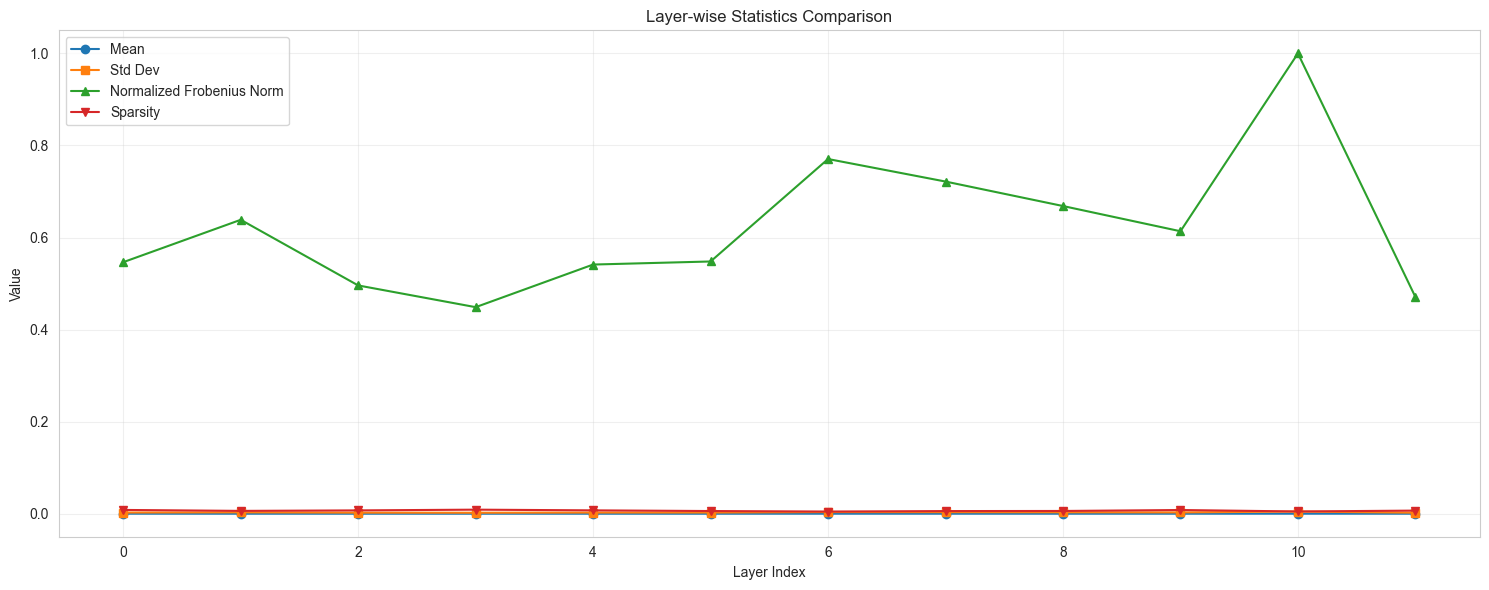

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

def plot_lora_layers_2d(checkpoint, layer_names):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Color map for different layers
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_names)))
    
    # First plot: Weight distribution curves
    for idx, layer_name in enumerate(layer_names):
        # Get LoRA matrices
        lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
        lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
        product = lora_a @ lora_b
        
        # Flatten the matrix
        weights = product.flatten()
        
        # Create kernel density estimate
        density = gaussian_kde(weights)
        xs = np.linspace(weights.min(), weights.max(), 200)
        ys = density(xs)
        
        # Plot the density curve
        ax1.plot(xs, ys, color=colors[idx], label=f'Layer {idx}', alpha=0.7)
    
    ax1.set_title('LoRA Weight Distributions Across Layers')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second plot: Singular values
    for idx, layer_name in enumerate(layer_names):
        lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
        lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
        product = lora_a @ lora_b
        
        # Compute singular values
        u, s, vh = np.linalg.svd(product)
        
        # Plot singular values
        ax2.plot(s[:50], color=colors[idx], label=f'Layer {idx}', alpha=0.7, marker='o', markersize=3)
    
    ax2.set_title('Top 50 Singular Values of LoRA Layers')
    ax2.set_xlabel('Singular Value Index')
    ax2.set_ylabel('Magnitude')
    ax2.set_yscale('log')  # Log scale for better visibility
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nLayer Statistics:")
    for idx, layer_name in enumerate(layer_names):
        lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
        lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
        product = lora_a @ lora_b
        u, s, vh = np.linalg.svd(product)
        
        print(f"\nLayer {idx}:")
        print(f"Max singular value: {s[0]:.4f}")
        print(f"Effective rank (>1e-5): {np.sum(s > 1e-5)}")
        print(f"Total variance explained by top 5 components: {(s[:5].sum() / s.sum()) * 100:.2f}%")

# Call the function
plot_lora_layers_2d(checkpoint, layer_names)

# Optional: Create an alternative visualization showing layer-wise comparisons
plt.figure(figsize=(15, 6))

# Store statistics for each layer
layer_stats = []
for layer_name in layer_names:
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    layer_stats.append({
        'mean': np.mean(product),
        'std': np.std(product),
        'norm': np.linalg.norm(product),
        'sparsity': np.mean(np.abs(product) < 1e-5)
    })

# Convert to arrays for plotting
means = [stats['mean'] for stats in layer_stats]
stds = [stats['std'] for stats in layer_stats]
norms = [stats['norm'] for stats in layer_stats]
sparsity = [stats['sparsity'] for stats in layer_stats]

plt.plot(means, label='Mean', marker='o')
plt.plot(stds, label='Std Dev', marker='s')
plt.plot(np.array(norms) / max(norms), label='Normalized Frobenius Norm', marker='^')
plt.plot(sparsity, label='Sparsity', marker='v')

plt.title('Layer-wise Statistics Comparison')
plt.xlabel('Layer Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

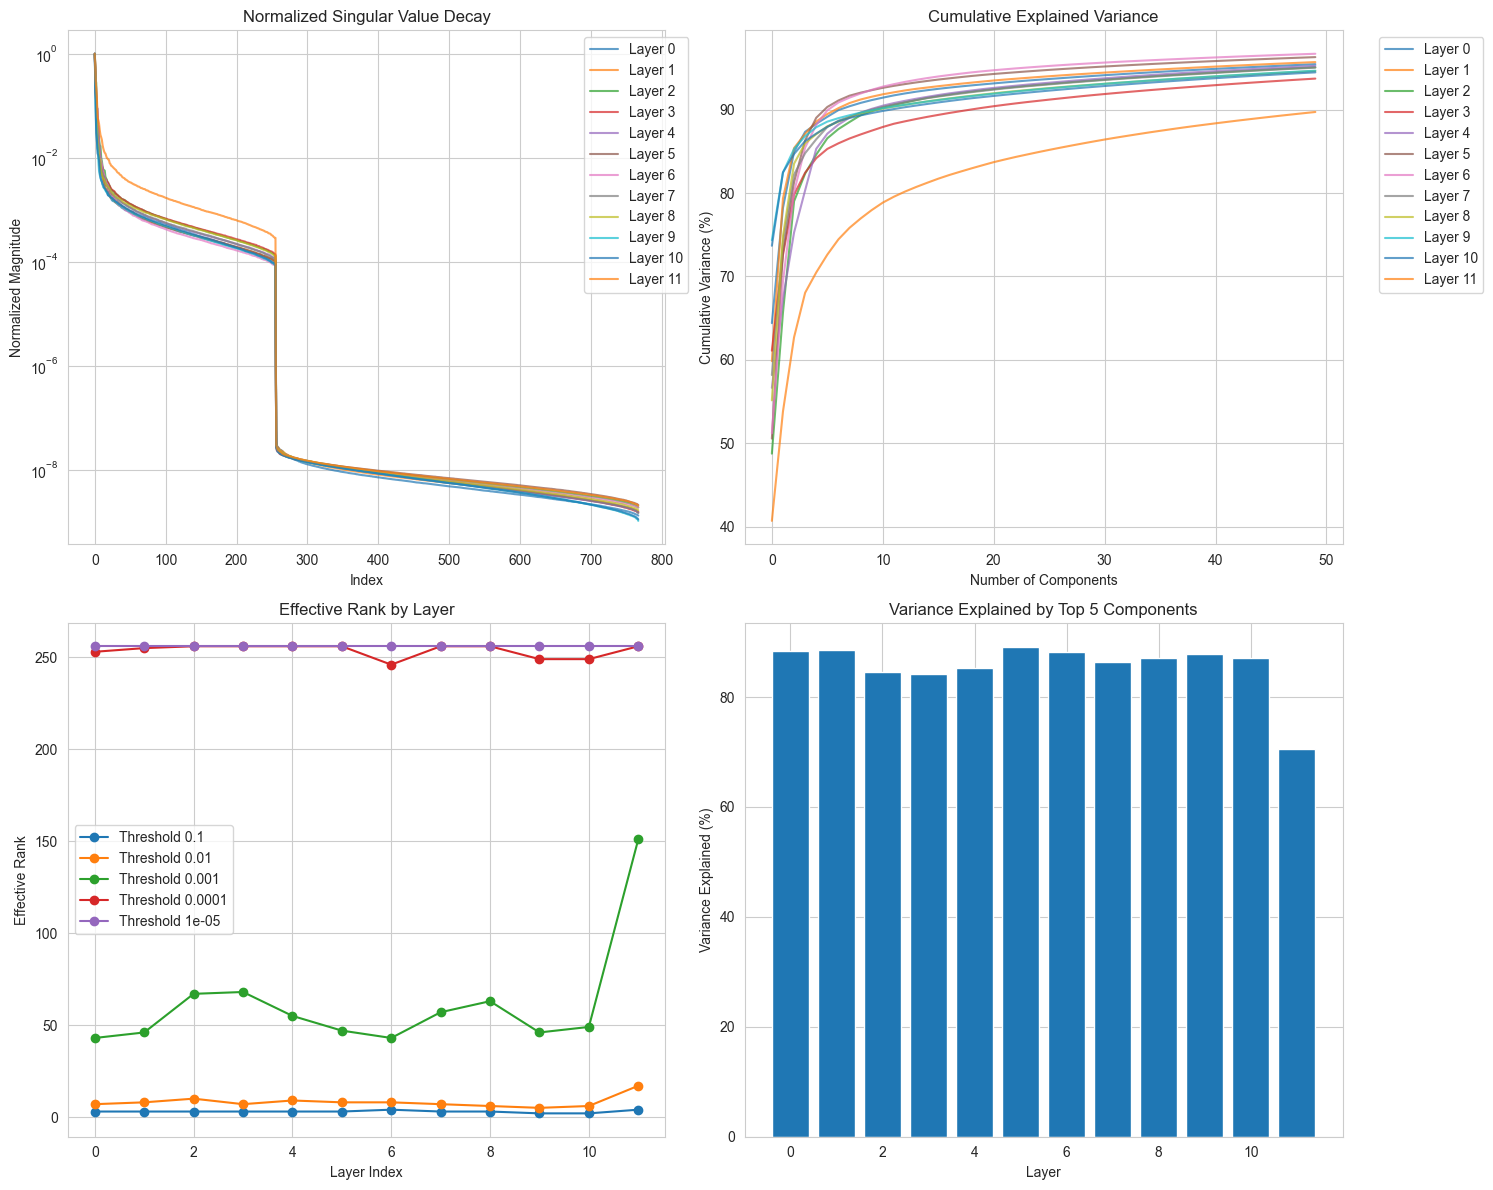


Singular Value Analysis Summary:

Layer 0:
- Variance explained by top 5 components: 88.3%
- Effective rank (>0.1% of max): 43

Layer 1:
- Variance explained by top 5 components: 88.6%
- Effective rank (>0.1% of max): 46

Layer 2:
- Variance explained by top 5 components: 84.6%
- Effective rank (>0.1% of max): 67

Layer 3:
- Variance explained by top 5 components: 84.2%
- Effective rank (>0.1% of max): 68

Layer 4:
- Variance explained by top 5 components: 85.3%
- Effective rank (>0.1% of max): 55

Layer 5:
- Variance explained by top 5 components: 89.0%
- Effective rank (>0.1% of max): 47

Layer 6:
- Variance explained by top 5 components: 88.2%
- Effective rank (>0.1% of max): 43

Layer 7:
- Variance explained by top 5 components: 86.5%
- Effective rank (>0.1% of max): 57

Layer 8:
- Variance explained by top 5 components: 87.1%
- Effective rank (>0.1% of max): 63

Layer 9:
- Variance explained by top 5 components: 87.9%
- Effective rank (>0.1% of max): 46

Layer 10:
- Variance expl

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create figure with multiple subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Singular Value Decay
for idx, layer_name in enumerate(layer_names):
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    # Compute singular values
    u, s, vh = np.linalg.svd(product)
    
    # Plot singular values
    ax1.plot(s/s[0], label=f'Layer {idx}', alpha=0.7)  # Normalized by largest singular value

ax1.set_title('Normalized Singular Value Decay')
ax1.set_xlabel('Index')
ax1.set_ylabel('Normalized Magnitude')
ax1.set_yscale('log')
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1))

# 2. Cumulative Explained Variance
for idx, layer_name in enumerate(layer_names):
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    u, s, vh = np.linalg.svd(product)
    cumulative_variance = np.cumsum(s) / np.sum(s) * 100
    
    ax2.plot(cumulative_variance[:50], label=f'Layer {idx}', alpha=0.7)

ax2.set_title('Cumulative Explained Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance (%)')
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1))

# 3. Effective Rank Analysis
effective_ranks = []
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for layer_name in layer_names:
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    u, s, vh = np.linalg.svd(product)
    ranks = [np.sum(s/s[0] > threshold) for threshold in thresholds]
    effective_ranks.append(ranks)

effective_ranks = np.array(effective_ranks)
for i, threshold in enumerate(thresholds):
    ax3.plot(effective_ranks[:, i], label=f'Threshold {threshold}', marker='o')

ax3.set_title('Effective Rank by Layer')
ax3.set_xlabel('Layer Index')
ax3.set_ylabel('Effective Rank')
ax3.grid(True)
ax3.legend()

# 4. Print summary statistics
summary_stats = []
for idx, layer_name in enumerate(layer_names):
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    u, s, vh = np.linalg.svd(product)
    
    var_explained_top5 = (np.sum(s[:5]) / np.sum(s)) * 100
    effective_rank = np.sum(s/s[0] > 1e-3)
    
    summary_stats.append({
        'layer': idx,
        'top5_var': var_explained_top5,
        'eff_rank': effective_rank
    })

# Plot summary as a bar chart
layers = [stat['layer'] for stat in summary_stats]
var_explained = [stat['top5_var'] for stat in summary_stats]

ax4.bar(layers, var_explained)
ax4.set_title('Variance Explained by Top 5 Components')
ax4.set_xlabel('Layer')
ax4.set_ylabel('Variance Explained (%)')
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nSingular Value Analysis Summary:")
for idx, stats in enumerate(summary_stats):
    print(f"\nLayer {idx}:")
    print(f"- Variance explained by top 5 components: {stats['top5_var']:.1f}%")
    print(f"- Effective rank (>0.1% of max): {stats['eff_rank']}")

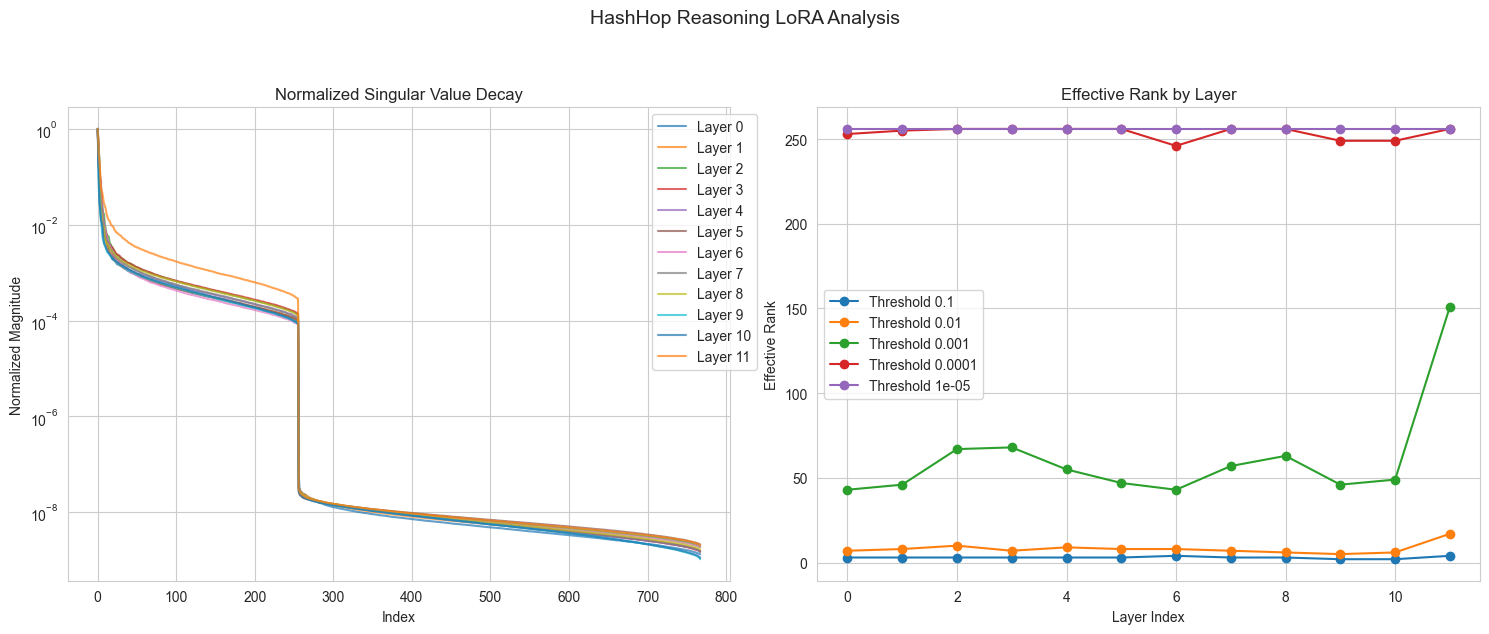

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle('HashHop Reasoning LoRA Analysis', fontsize=14, y=1.05)

# 1. Singular Value Decay
for idx, layer_name in enumerate(layer_names):
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    # Compute singular values
    u, s, vh = np.linalg.svd(product)
    
    # Plot singular values
    ax1.plot(s/s[0], label=f'Layer {idx}', alpha=0.7)  # Normalized by largest singular value

ax1.set_title('Normalized Singular Value Decay')
ax1.set_xlabel('Index')
ax1.set_ylabel('Normalized Magnitude')
ax1.set_yscale('log')
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1))

# 2. Effective Rank Analysis
effective_ranks = []
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for layer_name in layer_names:
    lora_a = checkpoint[f"{layer_name}.lora_A"].cpu().numpy()
    lora_b = checkpoint[f"{layer_name}.lora_B"].cpu().numpy()
    product = lora_a @ lora_b
    
    u, s, vh = np.linalg.svd(product)
    ranks = [np.sum(s/s[0] > threshold) for threshold in thresholds]
    effective_ranks.append(ranks)

effective_ranks = np.array(effective_ranks)
for i, threshold in enumerate(thresholds):
    ax2.plot(effective_ranks[:, i], label=f'Threshold {threshold}', marker='o')

ax2.set_title('Effective Rank by Layer')
ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Effective Rank')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()